In [46]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 노트북 안에 그래프 그리기
%matplotlib inline

# 한글 폰트 문제 해결
import platform

from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
else:
    print('Unknown system') 
    
# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [47]:
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [48]:
test = pd.read_csv("data/test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

## Feature Engineering
- casual
- registered

In [49]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 16)

In [50]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape

(6493, 13)

In [51]:
from sklearn.ensemble import RandomForestRegressor

rfModel_wind = RandomForestRegressor()
f_columns = ['season','weather','humidity','month','temp','year','hour','dayofweek','atemp']
X_train = train[f_columns]
y_r_label = train['registered']
y_c_label = train['casual']
print(X_train.shape)
print(y_r_label.shape)
print(y_c_label.shape)

(10886, 9)
(10886,)
(10886,)


In [52]:
X_test = test[f_columns]
X_test.shape

(6493, 9)

In [53]:
rfModel = RandomForestRegressor()
rfModel.fit(X_train, y_r_label)

RandomForestRegressor()

In [54]:
testRegisterdVal = rfModel.predict(X_test)

In [55]:
test['registered'] = testRegisterdVal
test['registered'].isnull().sum()

0

In [56]:
rfModel.fit(X_train, y_c_label)
testCasualVal = rfModel.predict(X_test)
test['casual'] = testCasualVal
test['casual'].isnull().sum()

0

<AxesSubplot:xlabel='hour', ylabel='value'>

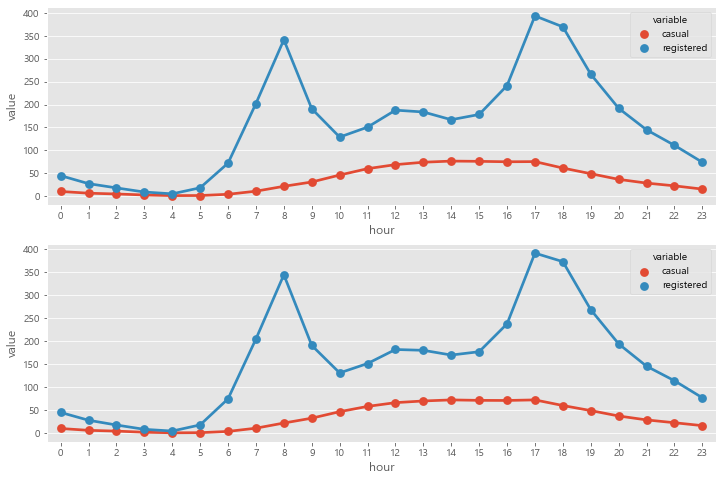

In [57]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(12,8)

hourTransformed = pd.melt(train[['hour','casual','registered']], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(['hour','variable'],sort=True)['value'].mean()).reset_index()
sns.pointplot(x=hourAggregated['hour'], y=hourAggregated['value'],hue=hourAggregated['variable'],hue_order=['casual','registered'], data=hourAggregated, join=True, ax=ax1)


hourTransformed = pd.melt(test[['hour','casual','registered']], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(['hour','variable'],sort=True)['value'].mean()).reset_index()
sns.pointplot(x=hourAggregated['hour'], y=hourAggregated['value'],hue=hourAggregated['variable'],hue_order=['casual','registered'], data=hourAggregated, join=True, ax=ax2)

[Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'test windspeed')]

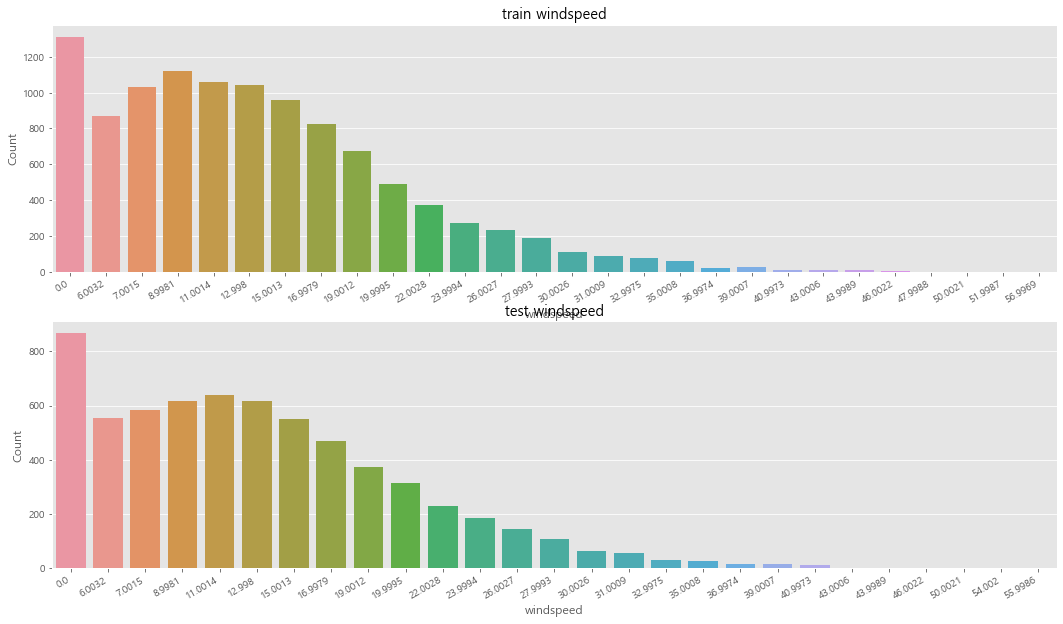

In [58]:
f,ax = plt.subplots(nrows=2, figsize = (18,10))

sns.countplot(data=train, x="windspeed", ax=ax[0])
plt.sca(ax[0])
plt.xticks(rotation=30, ha='right')
ax[0].set(ylabel='Count',title="train windspeed")

sns.countplot(data=test, x="windspeed", ax=ax[1])
plt.sca(ax[1])
plt.xticks(rotation=30, ha='right')
ax[1].set(ylabel='Count',title="test windspeed")

- 풍속의 0 값에 특정한 값을 넣어준다.
- 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이기 위해 머신러닝으로 예측 후 풍속의 값을 채워준다

In [59]:
# train 과 test 데이터셋을 합쳐준다
data = train.append(test)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

In [67]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestRegressor

# 풍속이 0인 데이터들의 값을 보정해 준다.

# 풍속이 0인것과 아닌 것을 나누어 준다.
dataWind0 = data[data['windspeed']==0]
dataWindNot0 = data[data['windspeed']!=0]

rfModel_wind = RandomForestRegressor()

# 풍속을 예측할 피처를 선택한다.
windColumns = ['season','weather','humidity','month','temp','year','atemp']

# 피처의 값을 바탕으로 풍속을 학습시킨다.
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0['windspeed'])

# 학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속을 예측한다.
wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])

 # 값이 0으로 기록된 풍속에 대해 예측한 값을 넣어준다.
dataWind0['windspeed'] = wind0Values

# dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
data = dataWindNot0.append(dataWind0)

data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

## Feature Selection

In [69]:
# 연속형 feature와 범주형 feature 로 나눠준다.

categoricalFeatureNames = ['season','holiday','workingday','weather','dayofweek','year','hour']
numericFeatureNames = ['temp','humidity','windspeed','atemp','casual','registered']
dropFeatures = ['count', 'datetime','month']

In [70]:
# 범주형 feature의 type을 category로 변경해 준다.
for var in categoricalFeatureNames :
    data[var] = data[var].astype('category')

## RMSLE
- Root Mean Square Logarithmic Error
- 오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root)으로 값이 작을수록 정밀도가 높다.
- 0에 가까운 값이 나올수록 정밀도가 높은 값이다.

In [71]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values , actual_values, convertExp = True):
    
    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    # 넘파이 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제값에 1을 더하고 로그를 씌운다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 예측값에서 실제값을 빼주고 제곱을 한다.
    diff = log_predict - log_actual
    diff = np.square(diff)
    
    # 평균을 낸다
    mean_diff = diff.mean()
    
    # 다시 루트를 씌워준다.
    score = np.sqrt(mean_diff)
    
    return score

In [73]:
X_train = data[pd.notnull(data['count'])].sort_values(by = ['datetime'])
X_test = data[~pd.notnull(data['count'])].sort_values(by = ['datetime'])

datetimecol = X_test['datetime']
y_train = X_train['count']

X_train = X_train.drop(dropFeatures, axis = 1)
X_test = X_test.drop(dropFeatures, axis = 1)

In [74]:
rfModel = RandomForestRegressor(n_estimators = 100)

y_train_log =  np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

RandomForestRegressor()

In [77]:
pred = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log), np.exp(pred), False)
print('RMSLE Value For RandomForest : {0:.5f}'.format(score))

RMSLE Value For RandomForest : 0.00505


In [78]:
# 예측
PredTest = rfModel.predict(X_test)

print(PredTest.shape)
PredTest[:10]

(6493,)


array([2.63974726, 1.94591015, 1.38629436, 1.38629436, 1.09861229,
       1.94591015, 3.61276315, 4.52209308, 5.40633622, 4.83960956])

[Text(0.5, 1.0, 'test')]

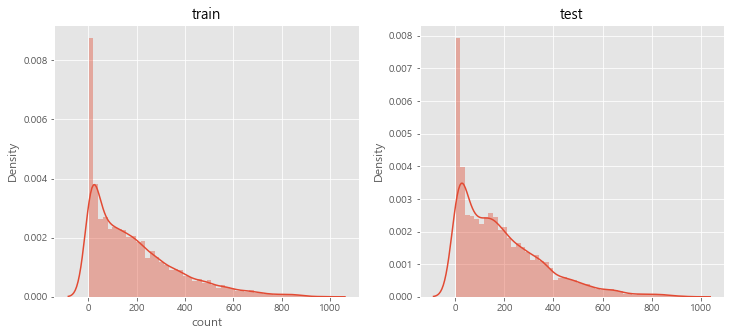

In [79]:
# 예측한 데이터 시각화
f, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12,5))

sns.distplot(y_train, ax = ax1, bins = 50)
ax1.set(title="train")

sns.distplot(np.exp(PredTest), ax = ax2, bins = 50)
ax2.set(title="test")

## Submit

In [83]:
submission = pd.read_csv("data/sampleSubmission.csv")
submission

submission['count'] = np.exp(PredTest)
print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,14.009662
1,2011-01-20 01:00:00,7.000000
2,2011-01-20 02:00:00,4.000000
3,2011-01-20 03:00:00,4.000000
4,2011-01-20 04:00:00,3.000000


In [84]:
submission.to_csv("data/Score_{0:.5f}_submission.csv".format(score), index=False)